In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/archive.zip /content/archive.zip

In [ ]:
!unzip archive.zip

In [4]:
!rm archive.zip

In [5]:
!pip install livelossplot

In [6]:
import numpy as np
import os, shutil
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Activation
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from livelossplot import PlotLossesKeras

In [7]:
print("Training Dataset")
for dir in os.listdir('train/'):
  cnt = len(os.listdir(os.path.join("train/", dir)))
  print(f"There are {cnt} {dir} images.")

Training Dataset
There are 4097 fear images.
There are 3171 surprise images.
There are 3995 angry images.
There are 4965 neutral images.
There are 436 disgust images.
There are 4830 sad images.
There are 7215 happy images.


In [8]:
print("Test Dataset")
for dir in os.listdir('test/'):
  cnt = len(os.listdir(os.path.join("test/", dir)))
  print(f"There are {cnt} {dir} images.")

Test Dataset
There are 1024 fear images.
There are 831 surprise images.
There are 958 angry images.
There are 1233 neutral images.
There are 111 disgust images.
There are 1247 sad images.
There are 1774 happy images.


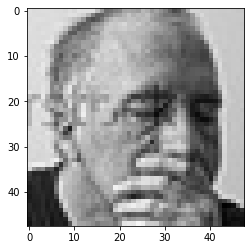

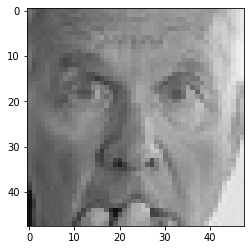

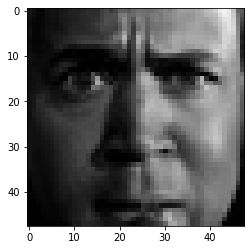

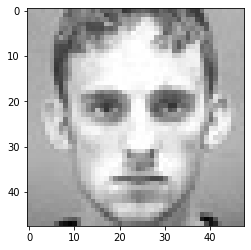

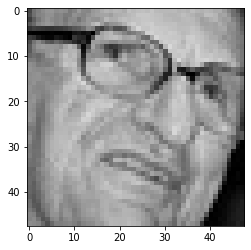

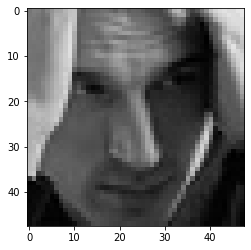

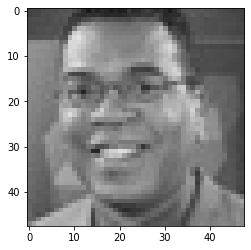

In [9]:
for dir in os.listdir("train/"):
  arr = os.listdir(os.path.join("train/", dir))
  img = cv2.imread(os.path.join("train", dir, arr[0]))
  plt.imshow(img, cmap='gray')
  plt.show()

In [10]:
img_size = 48
batch_size = 64

train_datagen = ImageDataGenerator(horizontal_flip=True, validation_split=0.25)
train_generator = train_datagen.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    subset='validation')

Found 21535 images belonging to 7 classes.
Found 7174 images belonging to 7 classes.


In [68]:
model = Sequential()

#Layer 1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

#Layer 3
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

#Layer 4
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

optimizer = Adam(learning_rate=0.003)#RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_139 (Bat (None, 48, 48, 64)        256       
_________________________________________________________________
activation_139 (Activation)  (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_139 (Dropout)        (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_140 (Bat (None, 24, 24, 128)     

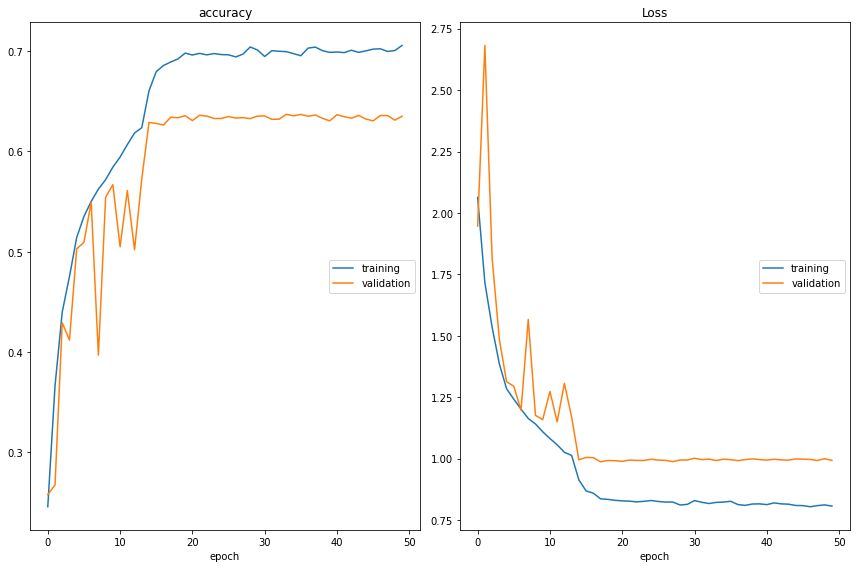

accuracy
	training         	 (min:    0.246, max:    0.706, cur:    0.706)
	validation       	 (min:    0.258, max:    0.637, cur:    0.635)
Loss
	training         	 (min:    0.804, max:    2.063, cur:    0.807)
	validation       	 (min:    0.987, max:    2.682, cur:    0.993)

Epoch 00050: val_accuracy did not improve from 0.63700


In [70]:
epochs=50
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint('weights.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=2, verbose=1, mode='min')
LRreduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_lr=0.00001)

callbacks = [PlotLossesKeras(), LRreduce, checkpoint]

history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

In [16]:
img_size = 48
batch_size = 32
test_datagen = ImageDataGenerator(horizontal_flip=False)

test_generator = test_datagen.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 7178 images belonging to 7 classes.


In [71]:
loss, accuracy = model.evaluate(test_generator)
print(f"Loss: {loss:.3f}\nAccuracy: {accuracy:.3f}")

225/225 [==============================] - 2s 10ms/step - loss: 0.9882 - accuracy: 0.6474
Loss: 0.988
Accuracy: 0.647


In [72]:
!cp /content/weights.h5 /content/gdrive/MyDrive/weights.h5

In [73]:
with open('model.json', 'w') as file:
  model_json = model.to_json()
  file.write(model_json)

In [74]:
!cp /content/model.json /content/gdrive/MyDrive/model.json